# 2019 L.POINT Big Data Competition

# Team: Beyonsei (Jaewon Kim, Seokyoon Seo, Jinsuk Son)

## TOPIC
###  Personalized Recommender System for Strengthening E-commerce Competitiveness of Lotte Shopping

### Import libraries

In [1]:
import random
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import dbscan
from sklearn.cluster import k_means
from sklearn.cluster import KMeans
from tqdm import tqdm_notebook
from collections import Counter

plt.rcParams['font.family'] = 'NanumGothic'
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:.3f}'.format

### Import Data
* Actions data is customer's online behavior data
* Transactions data is offline purchase data
* Users data is customer's demographic data
* Items data is product information data
* Weather data is including everyday weather and air quality information.
* Holiday data is including holiday information

In [2]:
actions = pd.read_csv(r'data/제6회 L.POINT Big Data Competition-분석용데이터-01.온라인 행동 정보.csv', encoding='utf-8')
transactions = pd.read_csv(r'data/제6회 L.POINT Big Data Competition-분석용데이터-02.거래 정보.csv', encoding='utf-8')
users = pd.read_csv(r'data/제6회 L.POINT Big Data Competition-분석용데이터-03.고객 Demographic 정보.csv', encoding='utf-8')
items = pd.read_csv(r'data/제6회 L.POINT Big Data Competition-분석용데이터-04.상품분류 정보.csv', encoding='utf-8')
weather = pd.read_csv(r'data/날씨대기정보_최종.csv', encoding='utf-8')
holiday = pd.read_csv(r'data/공휴일.csv', encoding='utf-8')

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Data cleansing

#### Actions data (customer's online behavior data)

In [3]:
# actions data cleansing
actions = actions.sort_values(['clnt_id', 'sess_id', 'hit_seq']).reset_index(drop=True)

tmp_id = actions['clnt_id'].to_dict()
tmp_page = actions['tot_pag_view_ct'].to_dict()
tmp_hr = actions['tot_sess_hr_v'].to_dict()
tmp_sess = actions['sess_id'].to_dict()
tmp_date = actions['sess_dt'].to_dict()
tmp_time = actions['hit_pss_tm'].to_dict()

## tot_pag_view_ct columns - null value processing
for i in actions[actions['tot_pag_view_ct'].isnull()].index:
    flag = False
    for k in [1, -1]:
        j = i + k
        while j < len(tmp_sess) if k == 1 else j > 0 and tmp_id[j] == tmp_id[i] and tmp_sess[j] == tmp_sess[i] and tmp_date[j] == tmp_date[i]:
            if not np.isnan(tmp_page[j]):
                tmp_page[i] = tmp_page[j]
                flag = True
                break
            j += k
        if flag:
            break
    if flag:
        continue
        
    cnt = 1
    for k in [1, -1]:
        j = i + k
        while j < len(tmp_sess) if k == 1 else j > 0 and tmp_id[j] == tmp_id[i] and tmp_sess[j] == tmp_sess[i] and tmp_date[j] == tmp_date[i]:
            cnt += 1
            j += k
    tmp_page[i] = cnt
actions['tot_pag_view_ct'] = tmp_page.values()

## tot_sess_hr_v column - null value processing
for i in actions[actions['tot_sess_hr_v'].isnull()].index:
    flag = False
    for k in [1, -1]:
        j = i + k
        while j < len(tmp_sess) if k == 1 else j > 0 and tmp_id[j] == tmp_id[i] and tmp_sess[j] == tmp_sess[i] and tmp_date[j] == tmp_date[i]:
            if not np.isnan(tmp_hr[j]):
                tmp_hr[i] = tmp_hr[j]
                flag = True
                break
            j += k
        if flag:
            break
    if flag:
        continue
    
    j = i
    while tmp_sess[j+1] == tmp_sess[i] and tmp_id[j+1] == tmp_id[i]:
        j += 1
    tmp_hr[i] = round(tmp_time[j] / 1000)

actions['tot_sess_hr_v'] = tmp_hr.values()

actions['dvc_ctg_nm'] = actions['dvc_ctg_nm'].fillna('unknown')

actions__ = actions.copy()

#### Transactions data (offline purchase data)

In [1]:
# transactions data cleansing
transactions = transactions.sort_values(['clnt_id', 'trans_id', 'trans_seq']).reset_index(drop=True)
transactions.loc[415329, 'buy_am'] = 16900
transactions.loc[417239, 'buy_am'] = 7200

transactions__ = transactions.copy()

NameError: name 'transactions' is not defined

#### Items data (product information)

In [5]:
# items data cleansing
items['pd_c'] = items['pd_c'].apply(lambda x : '{:0>4}'.format(x))
items.loc[195, 'clac_nm3'] = 'Packaged Side Dishes'
items.loc[523, 'clac_nm3'] = 'Frozen Instant Foods'
items.loc[666, 'clac_nm3'] = 'Rice'

items__ = items.copy()

#### Weather data (weather and air quality)

In [6]:
weather = weather.iloc[:, [0,1,5,7,8,-2,]]
weather.columns = ['de_dt', '기온', '강수량', '풍속', '습도', '미세먼지']
for i in ['기온', '풍속', '습도', '미세먼지']:
    weather[i] = pd.qcut(weather[i], 3, ['낮음', '보통', '높음'])
weather['강수량'] = weather['강수량'].apply(lambda x : '맑음' if x == 0 else '비')
weather['de_dt'] = weather['de_dt'].apply(lambda x : int(x[:4] + x[5:7] + x[8:]))
weather = weather.astype('str')
weather['de_dt'] = weather['de_dt'].astype(int)

#### Holiday data

In [7]:
holiday.columns = ['de_dt', '공휴일여부']
holiday['de_dt'] = holiday['de_dt'].apply(lambda x : int(x[:4] + x[5:7] + x[8:]))

### 고객 데이터 생성

In [8]:
user_table = users.set_index('clnt_id')
user_table.columns = ['고객_성별_여', '고객_연령대']
user_table.loc[user_table['고객_성별_여'] == 'F', '고객_성별_여'] = 1
user_table.loc[user_table['고객_성별_여'] == 'M', '고객_성별_여'] = 0
user_table['고객_연령대'][user_table['고객_연령대'] == 'unknown' ] = np.nan
user_table['고객_연령대'] = user_table['고객_연령대'].astype('float')

#### 구매패턴/소비성향

In [9]:
transactions = transactions.sort_values(['clnt_id', 'de_dt'])

In [10]:
trans_clnt_pt = transactions.pivot_table(index='clnt_id', values=['trans_seq', 'buy_am', 'buy_ct'], aggfunc=['sum', 'mean'])
trans_pdc_pt = transactions.pivot_table(index=['clnt_id', 'trans_id'], values='pd_c', aggfunc=lambda x : len(x.unique())).reset_index()

user_table['구매_구매주기'] = transactions.pivot_table(index='clnt_id', values='de_dt', aggfunc=lambda x : np.array(list(map(lambda x : x.days, np.diff(np.array(list(map(lambda x : dt.datetime.strptime(str(x), '%Y%m%d'), x.unique()))))))).mean() if len(x.unique()) > 1 else 91)

user_table['구매_총구매금액'] = trans_clnt_pt['sum']['buy_am']
user_table['구매_총구매수량'] = trans_clnt_pt['sum']['buy_ct']
user_table['구매_총거래횟수'] = transactions.pivot_table(index='clnt_id', values='trans_id', aggfunc=lambda x : len(x.unique()))

user_table['구매_장바구니평균금액'] = user_table['구매_총구매금액'] / user_table['구매_총거래횟수']
user_table['구매_장바구니평균수량'] = user_table['구매_총구매수량'] / user_table['구매_총거래횟수']

user_table['구매_구매상품종류개수평균'] = trans_pdc_pt.pivot_table(index='clnt_id', values='pd_c', aggfunc='mean')
user_table['구매_상품당구매수량평균'] = trans_clnt_pt['mean']['buy_ct']

#### 상황/맥락 선호 정보

In [11]:
transactions = transactions.merge(holiday, how='left', on='de_dt').fillna(0).merge(weather, how='left', on='de_dt')

In [12]:
weekdays = ['월', '화', '수', '목', '금', '토', '일']
transactions['요일'] = transactions['de_dt'].apply(lambda x : weekdays[dt.datetime.strptime(str(x), '%Y%m%d').weekday()])

In [13]:
아침출근 = ['06','07','08']
오전 = ['09', '10','11']
점심 = ['12', '13']
오후 = ['14', '15', '16', '17']
저녁퇴근 = ['18', '19']
밤 = ['20', '21', '22', '23']
심야 = ['00', '01', '02', '03', '04', '05']
d = {}
labels = ['아침출근', '오전', '점심' ,'오후', '저녁퇴근', '밤', '심야']
for i in labels:
    for j in globals()[i]:
        d[j] = i
        
transactions['de_tm'] = transactions['de_tm'].apply(lambda x : x[:2])
transactions['de_tm'] = transactions['de_tm'].apply(lambda x : d[x])
transactions.rename(columns={'de_tm':"시간대"}, inplace = True)

actions['hit_tm'] = actions['hit_tm'].apply(lambda x : x[:2])
actions['hit_tm'] = actions['hit_tm'].apply(lambda x : d[x])
actions.rename(columns={'hit_tm':"시간대"}, inplace = True)

In [14]:
tmp = pd.get_dummies(transactions.pivot_table(index=['clnt_id', 'trans_id'], values=['공휴일여부', '기온', '강수량', '풍속', '습도', '미세먼지', '요일', '시간대'], aggfunc=lambda x : x.iloc[0]), columns=['시간대', '강수량', '공휴일여부', '기온', '미세먼지', '습도', '요일', '풍속']).reset_index().pivot_table(index='clnt_id', aggfunc='sum')
for i in ['시간대', '공휴일여부', '기온', '강수량', '풍속', '습도', '미세먼지', '요일']:
    for j in transactions[i].unique():
        user_table['맥락_{}_{}_구매비율'.format(i, j)] = tmp['{}_{}'.format(i, j)] / user_table['구매_총거래횟수']

#### 상품선호정보

In [15]:
신선식품 = ['Fruits', 'Grains', 'Chilled Foods', 'Vegetables', 'Dairy Products', 
        'Frozen Foods', 'Sea Foods', 'Meats', 'Dried Sea Foods']

가공식품 = ['Spices / Seasonings', 'Substitute Foods', 'Beverages', 
        'Canned / Jarred Foods', 'Coffee / Tea', 'Snack Foods', 'Health Foods', 'Cooked Foods', 'Liquors / Alcoholic Beverages']
    
화장품 = ['Personal Care', 'Cosmetics / Beauty Care']

주방생활 = ['Detergents / Hygiene Goods', 'Kitchenware', 'Tableware / Cooking Utensils', 
        'Cleaning / Laundry / Bathroom Accessories',
        'Home / Kitchen Appliances', 'Tools / Safety Supplies', 'Health Care']
        
가구침구 = ['Bedding / Handicraft', 'Home Decor / Lighting', 'Furniture']
            
유아동 = ['Birth Supplies / Baby Products', 'Baby Foods',
         'Toy', "Kids' Clothing", 'Books / Records / Instruments']
         
기타 = ['Other Products', 'Others (Non-Products)', 'unknown']
         
스포츠레저 = ['Outdoor / Leisure Activities', 'Ball Game / Field Sports',
               'Health / Fitness Training', 'Sport Fashion', 
               'Seasonal Sports']
          
패션의류 = ['Fashion Accessories', 'Underwear / Socks and Hosiery / Homewear', 
            "Men's Clothing",  "Women's Clothing"]
          
가전컴퓨터 = ['Heating / Cooling Electronics', 'Cell Phones / Accessories', 
             'Video / Audio System Electronics', 'Computers',
             'Refrigerators and Washing Machines']
          
애완취미 = ['Gardening / Pets', 'Automotive Products',
        'Stationary / Office Supplies', 'Tenants / Restaurants',
        'Tobacco', 'Gift Certificates / Cards',
        'Travel / Leisure Services', 'Living / Rental Services',
        'Finance / Insurance Service']

대분류 = ['신선식품', '가공식품', '화장품', '주방생활', '가구침구', '유아동', '기타', '스포츠레저', '패션의류', '가전컴퓨터', '애완취미']
d = {}
for i in 대분류:
    for j in globals()[i]:
        d[j] = i

transactions = transactions.merge(items, on='pd_c', how='left').fillna('unknown')
transactions['대분류'] = transactions['clac_nm1'].apply(lambda x : d[x])
items['대분류'] = items['clac_nm1'].apply(lambda x : d[x])

In [16]:
tmp = transactions.pivot_table(index=['clnt_id', '대분류'], values=['buy_am', 'buy_ct'], aggfunc='sum').to_dict()
tmp2 = user_table['구매_총구매수량'].to_dict()
tmp3 = user_table['구매_총구매금액'].to_dict()
for i in 대분류:
    d1 = {}
    d2 = {}
    for j in transactions['clnt_id'].unique():
        d1[j] = tmp['buy_ct'].get((j,i), 0) / tmp2[j] if tmp3[j] else 0
        d2[j] = tmp['buy_am'].get((j,i), 0) / tmp3[j] if tmp3[j] else 0
    user_table['상품_{}수량비율'.format(i)] = pd.DataFrame(index=d1.keys(), data=d1.values(), columns=['상품_{}수량비율'.format(i)])
    user_table['상품_{}금액비율'.format(i)] = pd.DataFrame(index=d2.keys(), data=d2.values(), columns=['상품_{}구매비율'.format(i)])

#### 온라인 행동정보

In [17]:
actions['요일'] = actions['sess_dt'].apply(lambda x : weekdays[dt.datetime.strptime(str(x), '%Y%m%d').weekday()])

In [18]:
user_table['행동_방문주기'] = actions.pivot_table(index='clnt_id', values='sess_dt', aggfunc=lambda x : np.array(list(map(lambda x : x.days, np.diff(np.array(list(map(lambda x : dt.datetime.strptime(str(x), '%Y%m%d'), x.unique()))))))).mean() if len(x.unique()) > 1 else 91)
user_table['행동_총방문횟수'] = actions.pivot_table(index='clnt_id', values='sess_id', aggfunc=lambda x : len(x.unique()))
tmp = actions.pivot_table(index=['clnt_id', 'sess_id'], values='hit_seq', columns='요일', aggfunc=lambda x : 1 if x.iloc[0] == 1 else 0).reset_index().pivot_table(index='clnt_id', aggfunc='sum')
for i in ['월', '화', '수', '목', '금', '토', '일']:
    user_table['행동_요일_{}비중'.format(i)] = tmp[i] / user_table['행동_총방문횟수']
tmp = actions.pivot_table(index=['clnt_id', 'sess_id'], values='hit_seq', columns='시간대', aggfunc=lambda x : 1 if x.iloc[0] == 1 else 0).reset_index().pivot_table(index='clnt_id', aggfunc='sum')
for i in actions['시간대'].unique():
    user_table['행동_방문_{}비율'.format(i)] = tmp[i] / user_table['행동_총방문횟수']
user_table['행동_세션페이지조회수평균'] = actions.pivot_table(index=['clnt_id', 'sess_id'], values='tot_pag_view_ct', aggfunc=lambda x : x.iloc[0]).reset_index().pivot_table(index='clnt_id', values='tot_pag_view_ct', aggfunc='mean')
user_table['행동_총세션시간평균'] = actions.pivot_table(index=['clnt_id', 'sess_id'], values='tot_sess_hr_v', aggfunc=lambda x : x.iloc[0]).reset_index().pivot_table(index='clnt_id', values='tot_sess_hr_v', aggfunc='mean')
user_table['행동_페이지조회시간평균'] = user_table['행동_총세션시간평균'] / user_table['행동_세션페이지조회수평균']
tmp = actions.pivot_table(index=['clnt_id', 'sess_id'], values='hit_seq', columns='trfc_src', aggfunc=lambda x : 1 if x.iloc[0] == 1 else 0).reset_index().pivot_table(index='clnt_id', aggfunc='sum')
for i in actions['trfc_src'].unique():
    user_table['행동_유입채널_{}비중'.format(i)] = tmp[i] / user_table['행동_총방문횟수']
tmp = actions.pivot_table(index=['clnt_id', 'sess_id'], values='hit_seq', columns='dvc_ctg_nm', aggfunc=lambda x : 1 if x.iloc[0] == 1 else 0).reset_index().pivot_table(index='clnt_id', aggfunc='sum')
for i in actions['dvc_ctg_nm'].unique():
    user_table['행동_접속기기_{}비중'.format(i)] = tmp[i] / user_table['행동_총방문횟수']

#### 유통망 이용 비율

In [19]:
for i in ['A01', 'A02', 'A03', 'B01', 'B02', 'B03']:
    user_table['유통망_{}이용비율'.format(i)] = transactions.pivot_table(index=['clnt_id', 'trans_id'], values='biz_unit', aggfunc=lambda x : x.iloc[0]).reset_index().pivot_table(index='clnt_id', values='biz_unit', aggfunc=lambda x : len(x[x['biz_unit'] == i]) / len(x))

### 유통채널(A01, A02, A03)별 고객정보 테이블 생성

In [20]:
for platform in tqdm_notebook(['A01', 'A02', 'A03']):
    actions_ = actions__[actions__['biz_unit'] == platform].copy()
    transactions_ = transactions__[transactions__['biz_unit'] == platform].copy()
    
    globals()['user_table_{}'.format(platform)] = users.set_index('clnt_id')
    globals()['user_table_{}'.format(platform)].columns = ['고객_성별_여', '고객_연령대']
    globals()['user_table_{}'.format(platform)].loc[globals()['user_table_{}'.format(platform)]['고객_성별_여'] == 'F', '고객_성별_여'] = 1
    globals()['user_table_{}'.format(platform)].loc[globals()['user_table_{}'.format(platform)]['고객_성별_여'] == 'M', '고객_성별_여'] = 0
    globals()['user_table_{}'.format(platform)]['고객_연령대'][globals()['user_table_{}'.format(platform)]['고객_연령대'] == 'unknown' ] = np.nan
    globals()['user_table_{}'.format(platform)]['고객_연령대'] = globals()['user_table_{}'.format(platform)]['고객_연령대'].astype('float')

    transactions_ = transactions_.sort_values(['clnt_id', 'de_dt'])
    trans_clnt_pt = transactions_.pivot_table(index='clnt_id', values=['trans_seq', 'buy_am', 'buy_ct'], aggfunc=['sum', 'mean'])
    trans_pdc_pt = transactions_.pivot_table(index=['clnt_id', 'trans_id'], values='pd_c', aggfunc=lambda x : len(x.unique())).reset_index()

    globals()['user_table_{}'.format(platform)]['구매_구매주기'] = transactions_.pivot_table(index='clnt_id', values='de_dt', aggfunc=lambda x : np.array(list(map(lambda x : x.days, np.diff(np.array(list(map(lambda x : dt.datetime.strptime(str(x), '%Y%m%d'), x.unique()))))))).mean() if len(x.unique()) > 1 else 91)

    globals()['user_table_{}'.format(platform)]['구매_총구매금액'] = trans_clnt_pt['sum']['buy_am']
    globals()['user_table_{}'.format(platform)]['구매_총구매수량'] = trans_clnt_pt['sum']['buy_ct']
    globals()['user_table_{}'.format(platform)]['구매_총거래횟수'] = transactions_.pivot_table(index='clnt_id', values='trans_id', aggfunc=lambda x : len(x.unique()))

    globals()['user_table_{}'.format(platform)]['구매_장바구니평균금액'] = globals()['user_table_{}'.format(platform)]['구매_총구매금액'] / globals()['user_table_{}'.format(platform)]['구매_총거래횟수']
    globals()['user_table_{}'.format(platform)]['구매_장바구니평균수량'] = globals()['user_table_{}'.format(platform)]['구매_총구매수량'] / globals()['user_table_{}'.format(platform)]['구매_총거래횟수']

    globals()['user_table_{}'.format(platform)]['구매_구매상품종류개수평균'] = trans_pdc_pt.pivot_table(index='clnt_id', values='pd_c', aggfunc='mean')
    globals()['user_table_{}'.format(platform)]['구매_상품당구매수량평균'] = trans_clnt_pt['mean']['buy_ct']

    transactions_ = transactions_.merge(holiday, how='left', on='de_dt').fillna(0).merge(weather, how='left', on='de_dt')
    weekdays = ['월', '화', '수', '목', '금', '토', '일']
    transactions_['요일'] = transactions_['de_dt'].apply(lambda x : weekdays[dt.datetime.strptime(str(x), '%Y%m%d').weekday()])

    d = {}
    labels = ['아침출근', '오전', '점심' ,'오후', '저녁퇴근', '밤', '심야']
    for i in labels:
        for j in globals()[i]:
            d[j] = i
            
    transactions_['de_tm'] = transactions_['de_tm'].apply(lambda x : x[:2])
    transactions_['de_tm'] = transactions_['de_tm'].apply(lambda x : d[x])
    transactions_.rename(columns={'de_tm':"시간대"}, inplace = True)

    actions_['hit_tm'] = actions_['hit_tm'].apply(lambda x : x[:2])
    actions_['hit_tm'] = actions_['hit_tm'].apply(lambda x : d[x])
    actions_.rename(columns={'hit_tm':"시간대"}, inplace = True)

    tmp = pd.get_dummies(transactions_.pivot_table(index=['clnt_id', 'trans_id'], values=['공휴일여부', '기온', '강수량', '풍속', '습도', '미세먼지', '요일', '시간대'], aggfunc=lambda x : x.iloc[0]), columns=['시간대', '강수량', '공휴일여부', '기온', '미세먼지', '습도', '요일', '풍속']).reset_index().pivot_table(index='clnt_id', aggfunc='sum')
    for i in ['시간대', '공휴일여부', '기온', '강수량', '풍속', '습도', '미세먼지', '요일']:
        for j in transactions_[i].unique():
            globals()['user_table_{}'.format(platform)]['맥락_{}_{}_구매비율'.format(i, j)] = tmp['{}_{}'.format(i, j)] / globals()['user_table_{}'.format(platform)]['구매_총거래횟수']


    대분류 = ['신선식품', '가공식품', '화장품', '주방생활', '가구침구', '유아동', '기타', '스포츠레저', '패션의류', '가전컴퓨터', '애완취미']
    d = {}
    for i in 대분류:
        for j in globals()[i]:
            d[j] = i

    transactions_ = transactions_.merge(items__, on='pd_c', how='left').fillna('unknown')
    transactions_['대분류'] = transactions_['clac_nm1'].apply(lambda x : d[x])

    tmp = transactions_.pivot_table(index=['clnt_id', '대분류'], values=['buy_am', 'buy_ct'], aggfunc='sum').to_dict()
    tmp2 = globals()['user_table_{}'.format(platform)]['구매_총구매수량'].to_dict()
    tmp3 = globals()['user_table_{}'.format(platform)]['구매_총구매금액'].to_dict()
    for i in 대분류:
        d1 = {}
        d2 = {}
        for j in transactions_['clnt_id'].unique():
            d1[j] = tmp['buy_ct'].get((j,i), 0) / tmp2[j] if tmp3[j] else 0
            d2[j] = tmp['buy_am'].get((j,i), 0) / tmp3[j] if tmp3[j] else 0
        globals()['user_table_{}'.format(platform)]['상품_{}수량비율'.format(i)] = pd.DataFrame(index=d1.keys(), data=d1.values(), columns=['상품_{}수량비율'.format(i)])
        globals()['user_table_{}'.format(platform)]['상품_{}금액비율'.format(i)] = pd.DataFrame(index=d2.keys(), data=d2.values(), columns=['상품_{}구매비율'.format(i)])

    actions_['요일'] = actions_['sess_dt'].apply(lambda x : weekdays[dt.datetime.strptime(str(x), '%Y%m%d').weekday()])
    globals()['user_table_{}'.format(platform)]['행동_방문주기'] = actions_.pivot_table(index='clnt_id', values='sess_dt', aggfunc=lambda x : np.array(list(map(lambda x : x.days, np.diff(np.array(list(map(lambda x : dt.datetime.strptime(str(x), '%Y%m%d'), x.unique()))))))).mean() if len(x.unique()) > 1 else 91)
    globals()['user_table_{}'.format(platform)]['행동_총방문횟수'] = actions_.pivot_table(index='clnt_id', values='sess_id', aggfunc=lambda x : len(x.unique()))
    tmp = actions_.pivot_table(index=['clnt_id', 'sess_id'], values='hit_seq', columns='요일', aggfunc=lambda x : 1 if x.iloc[0] == 1 else 0).reset_index().pivot_table(index='clnt_id', aggfunc='sum')
    for i in ['월', '화', '수', '목', '금', '토', '일']:
        globals()['user_table_{}'.format(platform)]['행동_요일_{}비중'.format(i)] = tmp[i] / globals()['user_table_{}'.format(platform)]['행동_총방문횟수']
    tmp = actions_.pivot_table(index=['clnt_id', 'sess_id'], values='hit_seq', columns='시간대', aggfunc=lambda x : 1 if x.iloc[0] == 1 else 0).reset_index().pivot_table(index='clnt_id', aggfunc='sum')
    for i in actions_['시간대'].unique():
        globals()['user_table_{}'.format(platform)]['행동_방문_{}비율'.format(i)] = tmp[i] / globals()['user_table_{}'.format(platform)]['행동_총방문횟수']
    globals()['user_table_{}'.format(platform)]['행동_세션페이지조회수평균'] = actions_.pivot_table(index=['clnt_id', 'sess_id'], values='tot_pag_view_ct', aggfunc=lambda x : x.iloc[0]).reset_index().pivot_table(index='clnt_id', values='tot_pag_view_ct', aggfunc='mean')
    globals()['user_table_{}'.format(platform)]['행동_총세션시간평균'] = actions_.pivot_table(index=['clnt_id', 'sess_id'], values='tot_sess_hr_v', aggfunc=lambda x : x.iloc[0]).reset_index().pivot_table(index='clnt_id', values='tot_sess_hr_v', aggfunc='mean')
    globals()['user_table_{}'.format(platform)]['행동_페이지조회시간평균'] = globals()['user_table_{}'.format(platform)]['행동_총세션시간평균'] / globals()['user_table_{}'.format(platform)]['행동_세션페이지조회수평균']
    tmp = actions_.pivot_table(index=['clnt_id', 'sess_id'], values='hit_seq', columns='trfc_src', aggfunc=lambda x : 1 if x.iloc[0] == 1 else 0).reset_index().pivot_table(index='clnt_id', aggfunc='sum')
    for i in actions_['trfc_src'].unique():
        globals()['user_table_{}'.format(platform)]['행동_유입채널_{}비중'.format(i)] = tmp[i] / globals()['user_table_{}'.format(platform)]['행동_총방문횟수']
    tmp = actions_.pivot_table(index=['clnt_id', 'sess_id'], values='hit_seq', columns='dvc_ctg_nm', aggfunc=lambda x : 1 if x.iloc[0] == 1 else 0).reset_index().pivot_table(index='clnt_id', aggfunc='sum')
    for i in actions_['dvc_ctg_nm'].unique():
        globals()['user_table_{}'.format(platform)]['행동_접속기기_{}비중'.format(i)] = tmp[i] / globals()['user_table_{}'.format(platform)]['행동_총방문횟수']

### 거래 테이블

#### 거래패턴 정보

In [21]:
trans_table = transactions.pivot_table(index=['trans_id', 'clnt_id']).reset_index()[['trans_id', 'clnt_id']].set_index('trans_id')
trans_table['구매_행개수'] = transactions.pivot_table(index='trans_id', values='clnt_id', aggfunc='count')
trans_table['구매_총거래액'] = transactions.pivot_table(index='trans_id', values='buy_am', aggfunc='sum')
trans_table['구매_총거래수량'] = transactions.pivot_table(index='trans_id', values='buy_ct', aggfunc='sum')
trans_table['구매_행평균거래액'] = trans_table['구매_총거래액'] / trans_table['구매_행개수']
trans_table['구매_행평균거래수량'] = trans_table['구매_총거래수량'] / trans_table['구매_행개수']
trans_table['구매_재품당가격'] = trans_table['구매_총거래액'] / trans_table['구매_총거래수량']

#### 상황/맥락 성호 정보

In [22]:
trans_table['맥락_요일'] = transactions.pivot_table(index='trans_id', values='요일', aggfunc=lambda x : x.iloc[0])
trans_table['맥락_시간대'] = transactions.pivot_table(index='trans_id', values='시간대', aggfunc=lambda x : x.iloc[0])
trans_table['맥락_공휴일여부'] = transactions.pivot_table(index='trans_id', values='공휴일여부', aggfunc=lambda x : x.iloc[0])
trans_table['맥락_기온'] = transactions.pivot_table(index='trans_id', values='기온', aggfunc=lambda x : x.iloc[0])
trans_table['맥락_강수량'] = transactions.pivot_table(index='trans_id', values='강수량', aggfunc=lambda x : x.iloc[0])
trans_table['맥락_습도'] = transactions.pivot_table(index='trans_id', values='습도', aggfunc=lambda x : x.iloc[0])
trans_table['맥락_미세먼지'] = transactions.pivot_table(index='trans_id', values='미세먼지', aggfunc=lambda x : x.iloc[0])

#### 상품 선호 정보

In [23]:
tmp = transactions.pivot_table(index=['trans_id', '대분류'], values='buy_ct', aggfunc='sum').reset_index().pivot_table(index='trans_id', columns='대분류', values='buy_ct')
for i in transactions['대분류'].unique():
    trans_table['상품_{}수량비율'.format(i)] = tmp[i].fillna(0) / trans_table['구매_총거래수량']
    
tmp = transactions.pivot_table(index=['trans_id', '대분류'], values='buy_am', aggfunc='sum').reset_index().pivot_table(index='trans_id', columns='대분류', values='buy_am')
for i in transactions['대분류'].unique():
    trans_table['상품_{}금액비율'.format(i)] = tmp[i].fillna(0) / trans_table['구매_총거래액']

#### 온라인 행동 정보

In [24]:
visited = set()

for column in actions.columns:
    globals()['{}_dict'.format(column)] = actions[column].to_dict()

last_clnt_id = -1
last_sess_id = 1
sess_cnt = 0
seq_cnt = 0
seq_cnt_in_sess = 0

action_type_by_sess = {i:0 for i in range(8)}
action_type_by_trans = {i:0 for i in range(8)}
last_hit_pss_tm = 0
is_sech_kwd = 0

data = []

for i in actions.index:
    if last_clnt_id != clnt_id_dict[i]:
        last_clnt_id = clnt_id_dict[i]
        last_sess_id = 1
        sess_cnt = 0
        seq_cnt = 0
        seq_cnt_in_sess = 0
        action_type_by_sess = {i:0 for i in range(8)}
        action_type_by_trans = {i:0 for i in range(8)}
        last_hit_pss_tm = 0
        is_sech_kwd = 0
        
    elif last_sess_id != sess_id_dict[i]:
        last_sess_id = sess_id_dict[i]
        sess_cnt += 1
        seq_cnt_in_sess = 0
        action_type_by_sess = {i:0 for i in range(8)}
        last_hit_pss_tm = 0
        is_sech_kwd = 0
        
    if action_type_dict[i] == 0:
        is_sech_kwd = 1
    action_type_by_sess[action_type_dict[i]] += 1
    action_type_by_trans[action_type_dict[i]] += 1
    
    
    if not np.isnan(trans_id_dict[i]) and trans_id_dict[i] not in visited:
        visited.add(trans_id_dict[i])
        data.append(
            (trans_id_dict[i], clnt_id_dict[i], sess_cnt, seq_cnt, hit_seq_dict[i],
             action_type_by_sess[0] / sum(action_type_by_sess.values()), action_type_by_sess[1] / sum(action_type_by_sess.values()),
             action_type_by_sess[2] / sum(action_type_by_sess.values()), action_type_by_sess[3] / sum(action_type_by_sess.values()),
             action_type_by_sess[4] / sum(action_type_by_sess.values()), action_type_by_sess[5] / sum(action_type_by_sess.values()),
             action_type_by_sess[6] / sum(action_type_by_sess.values()), action_type_by_sess[7] / sum(action_type_by_sess.values()),
             action_type_by_trans[0] / sum(action_type_by_trans.values()), action_type_by_trans[1] / sum(action_type_by_trans.values()),
             action_type_by_trans[2] / sum(action_type_by_trans.values()), action_type_by_trans[3] / sum(action_type_by_trans.values()),
             action_type_by_trans[4] / sum(action_type_by_trans.values()), action_type_by_trans[5] / sum(action_type_by_trans.values()),
             action_type_by_trans[6] / sum(action_type_by_trans.values()), action_type_by_trans[7] / sum(action_type_by_trans.values()),
             hit_pss_tm_dict[i] - last_hit_pss_tm, is_sech_kwd, tot_pag_view_ct_dict[i],
             tot_sess_hr_v_dict[i], trfc_src_dict[i], dvc_ctg_nm_dict[i]
            )
        )
        sess_cnt = 0
        seq_cnt = 0
        action_type_by_trans = {i:0 for i in range(8)}
        last_hit_pss_tm = hit_pss_tm_dict[i]
        is_sech_kwd = 0
    elif not np.isnan(trans_id_dict[i]) and trans_id_dict[i] in visited:
        sess_cnt = 0
        seq_cnt = 0
        action_type_by_trans = {i:0 for i in range(8)}
        is_sech_kwd = 0
    else:
        seq_cnt += 1
        seq_cnt_in_sess += 1

In [25]:
online_data = pd.DataFrame(data, columns=('trans_id', 'clnt_id', '행동_거래_세션개수', '행동_거래_시퀀스개수', '행동_거래_시퀀스번호',
                            '행동_세션_검색비율', '행동_세션_제품목록비율', '행동_세션_세부정보비율', '행동_세션_장바구니추가비율',
                            '행동_세션_장바구니삭제비율', '행동_세션_결제시도비율', '행동_세션_구매완료비율', '행동_세션_구매환불비율',
                            '행동_거래_검색비율', '행동_거래_제품목록비율', '행동_거래_세부정보비율', '행동_거래_장바구니추가비율',
                            '행동_거래_장바구니삭제비율', '행동_거래_결제시도비율', '행동_거래_구매완료비율', '행동_거래_구매환불비율',
                            '행동_세션_경과시간', '행동_검색여부', '행동_총페이지수', '행동_총세션시간', '행동_유입경로', '행동_기기유형'
                           )
            ).sort_values('trans_id')
online_data['trans_id'] = online_data['trans_id'].astype('int')
online_data['clnt_id'] = online_data['clnt_id'].astype('int')

In [26]:
trans_table = trans_table.reset_index().merge(online_data, how='outer', on=['trans_id', 'clnt_id']).sort_values('trans_id').reset_index(drop=True)

### 유저 군집화 + 코드화

In [27]:
군집화고객 = user_table[user_table['구매_총구매금액'].notnull()]
스케일고객 = 군집화고객.copy()
for i in ['구매_구매주기', '구매_총구매금액', '구매_총구매수량', '구매_총거래횟수', '구매_장바구니평균금액', '구매_장바구니평균수량', '구매_구매상품종류개수평균', '구매_상품당구매수량평균', '행동_방문주기', '행동_총방문횟수', '행동_세션페이지조회수평균', '행동_총세션시간평균', '행동_페이지조회시간평균']:
    j = 100
    while True:
        try:
            스케일고객[i] = pd.qcut(스케일고객[i], j, range(j)).astype('int')
            break
        except:
            j -= 1
mm = MinMaxScaler()
스케일고객 = pd.DataFrame(mm.fit_transform(스케일고객), index=스케일고객.index, columns=스케일고객.columns)

users_ = 스케일고객.copy()
for i in ['고객_', '구매_', '맥락_', '상품_', '행동_', '유통망_']:
    tmp = list(filter(lambda x : i in x, users_.columns))
    users_[tmp] /= len(tmp)

#### 유저나 유저 군집 정보를 한눈에 보기 쉽게하기 위하여 한줄의 코드로 요약정보를 생성하는 함수

In [28]:
def to_code(data):
    code = ''
    if data['고객_성별_여'] > 0.5:
        code += 'F-'
    else:
        code += 'M-'
        
    code += '{}//'.format(int(np.round(data['고객_연령대'] * 50 + 10, -1)))
    
    if data['구매_총구매금액'] + data['구매_총구매금액'] < 0.666:
        code += '구매력:낮음-'
    elif data['구매_총구매금액'] + data['구매_총구매금액'] > 1.333:
        code += '구매력:높음-'
    else:
        code += '구매력:보통-'
        
    if data['구매_구매주기'] + data['구매_구매주기'] < 0.333:
        code += '구매주기:높음//'
    elif data['구매_구매주기'] + data['구매_구매주기'] > 0.666:
        code += '구매주기:낮음//'
    else:
        code += '구매주기:보통//'
    
    tmp = 0
    tmp_code = ''
    for i, j in zip(['오전', '점심', '오후', '저녁퇴근', '밤', '심야'], ['오전', '점심', '오후', '저녁', '밤', '심야']):
        if data['맥락_시간대_{}_구매비율'.format(i)] > tmp:
            tmp = data['맥락_시간대_{}_구매비율'.format(i)]
            tmp_code = j
    code += tmp_code + '-'
    
    tmp = 0
    tmp_code = ''
    for i, j in zip(['월', '화', '수', '목', '금', '토', '일'], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']):
        if data['맥락_요일_{}_구매비율'.format(i)] > tmp:
            tmp = data['맥락_요일_{}_구매비율'.format(i)]
            tmp_code = i
    code += tmp_code + '-'
    
    tmp = 0
    tmp_code = ''
    for i, j in zip(['높음', '보통', '낮음'], ['T:H', 'T:M', 'T:L']):
        if data['맥락_기온_{}_구매비율'.format(i)] > tmp:
            tmp = data['맥락_기온_{}_구매비율'.format(i)]
            tmp_code = i
    code += '기온' + tmp_code + '-'
    
    if data['맥락_강수량_맑음_구매비율'] > 0.5:
        code += '맑음-'
    else:
        code += '우천-'
        
    tmp = 0
    tmp_code = ''
    for i, j in zip(['높음', '보통', '낮음'], ['D:H', 'D:M', 'D:L']):
        if data['맥락_미세먼지_{}_구매비율'.format(i)] > tmp:
            tmp = data['맥락_미세먼지_{}_구매비율'.format(i)]
            tmp_code = i
    code += '미세먼지:' + tmp_code + '//'
    
    tmp = []
    for i, j in zip(sorted(transactions['대분류'].unique()), ['Fo', 'Fb', 'Ac', 'Ot', 'Sl', 'Fo', 'Ph', 'Kc', 'Kl', 'Fa', 'Co']):
        tmp.append((data['상품_{}금액비율'.format(i)] + data['상품_{}수량비율'.format(i)], i))
    tmp.sort()
    k = -2
    if tmp[-1][1] == tmp[-2][1]:
        k=-3
    code += '({}, {})//'.format(tmp[-1][1], tmp[-3][1])
    
    tmp = []
    for i, j in zip(sorted(actions['trfc_src'].unique()), ['Di', 'Po', 'Po', 'Po', 'Pu', 'We', 'NA']):
        tmp.append((data['행동_유입채널_{}비중'.format(i)], i))
    tmp.sort()
    code += '유입채널:' + tmp[-1][1] + '-'
    
    tmp = []
    for i, j in zip(sorted(actions['dvc_ctg_nm'].unique()), ['PC', 'Ma', 'Mw', 'NA']):
        tmp.append((data['행동_접속기기_{}비중'.format(i)], i))
    tmp.sort()
    code += '접속기기:' + tmp[-1][1]
    
    return code
        
# to_code(스케일고객[(users_['군집'] == 0).values].mean())

#### 500명의 유저 정보 커브

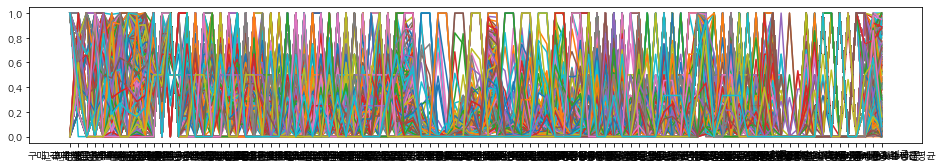

In [29]:
ax = plt.figure(figsize=(16,2.5))
legend_list = []
tmp = []
for i in tqdm_notebook(스케일고객.index[:500]):
    legend_list.append(i)
    sns.lineplot(스케일고객.loc[i].index, 스케일고객.loc[i].values)

#### 최적 클러스터 개수를 정하기 위한 Elbow method

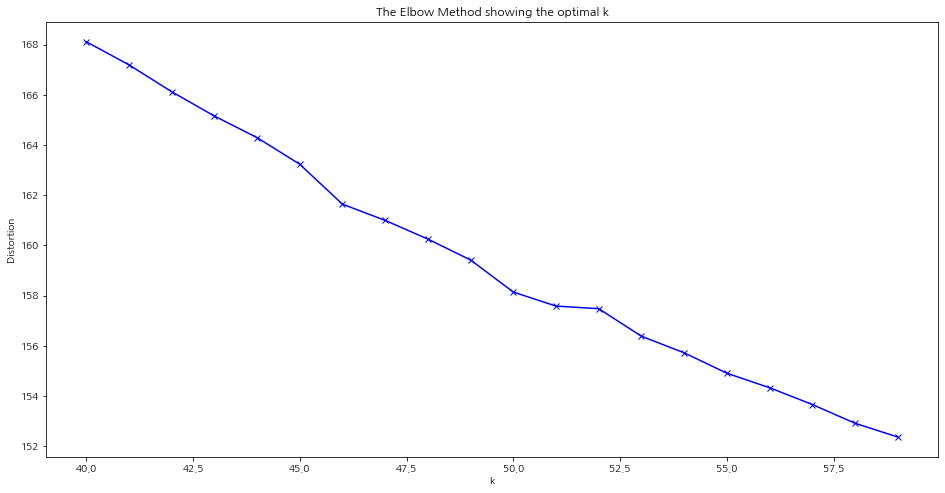

In [30]:
distortions = []
K = range(40,60)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(users_)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### 모든 식별고객에게 군집을 부여하기 위해 Kmeans 알고리즘을 이용하여 군집화

군집에 포함된 고객수와 구매력을 곱한 값임 군집 규모가 1억원이 넘는 군집만을 표시

군집:30	고객수:431	구매력:728782	규모:314104846
코드:F-40//구매력:높음-구매주기:보통//오후-월-기온보통-맑음-미세먼지:낮음//(신선식품, 주방생활)//유입채널:DIRECT-접속기기:unknown

군집:39	고객수:134	구매력:2196740	규모:294363190
코드:M-30//구매력:높음-구매주기:보통//오후-토-기온높음-맑음-미세먼지:낮음//(신선식품, 주방생활)//유입채널:unknown-접속기기:unknown

군집:17	고객수:320	구매력:905081	규모:289625946
코드:F-40//구매력:높음-구매주기:낮음//오후-토-기온높음-맑음-미세먼지:낮음//(신선식품, 패션의류)//유입채널:unknown-접속기기:mobile_web

군집:27	고객수:272	구매력:1057798	규모:287721083
코드:F-30//구매력:높음-구매주기:보통//오후-토-기온보통-맑음-미세먼지:낮음//(신선식품, 유아동)//유입채널:unknown-접속기기:mobile_web

군집:36	고객수:241	구매력:1127610	규모:271754005
코드:F-50//구매력:높음-구매주기:낮음//밤-목-기온보통-맑음-미세먼지:낮음//(패션의류, 가공식품)//유입채널:unknown-접속기기:mobile_app

군집:14	고객수:331	구매력:802970	규모:265783235
코드:F-40//구매력:높음-구매주기:높음//오후-월-기온보통-맑음-미세먼지:낮음//(신선식품, 주방생활)//유입채널:DIRECT-접속기기:unknown

군집:28	고객수:481	구매력:544025	규모:261675785
코드:F-30//구매력:보통-구매주기:높음//오후-월-기온낮음-맑음-미세먼지:낮음//(신선식품, 주방생활)//유입채널:DIRECT-접속기기:unknown

군집:13	고객수:260	구매력:1002021	규모:260525448
코드:F-40//구매력:높음-구매주기:낮음//오후-토-기온높음-맑음-미세먼지:낮음//(패션의류, 가공식품)//유입채널:unknow

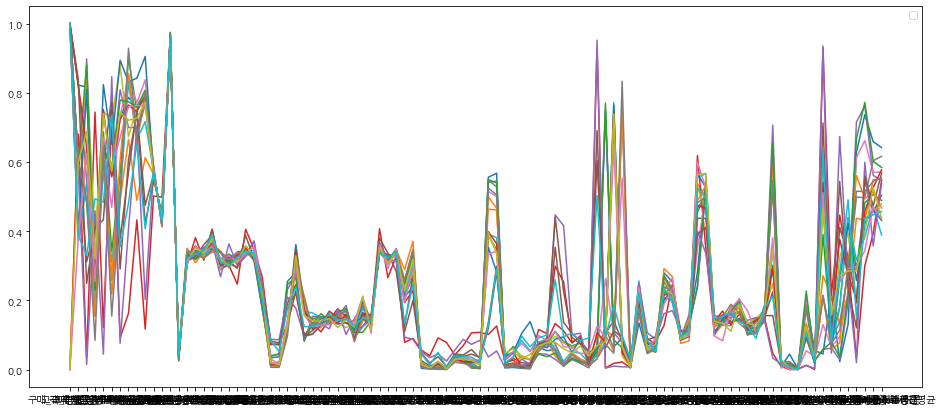

In [31]:
db = k_means(users_, 50)
users_['군집'] = db[1]
ax = plt.figure(figsize=(16,7))
legend_list = []
tmp = []
for i in range(len(set(db[1]))):
    legend_list.append(i)
    구매력 = 군집화고객['구매_총구매금액'][(users_['군집'] == i).values].mean()
    고객수 = len(스케일고객[users_['군집'] == i])
    if 구매력 * 고객수 > 100000000:
        sns.lineplot(스케일고객[users_['군집'] == i].mean().index, 스케일고객[users_['군집'] == i].mean().values)
        tmp.append((구매력 * 고객수, i, '군집:{}\t고객수:{}\t구매력:{}\t규모:{}\n코드:{}'.format(i, 고객수, round(구매력), round(구매력 * 고객수), to_code(스케일고객[users_['군집'] == i].mean()))))
tmp.sort(reverse=True)
for i in range(len(tmp)):
    print(tmp[i][2])
    print()
print(len(tmp))
plt.legend([])
plt.xlim
plt.show()

### 알고리즘 1: 고객수 증대

고객이 사용하는 채널과, 고객의 특성을 기반으로 알맞은 추가 플랫폼을 추천하여 고객수를 증대

#### 유통채널 연관지수 생성

유통채널간 조건부 확률과 유통채널 이용율을 기반으로 유통채널간 연관지수 생성

In [32]:
tmp = transactions.pivot_table(index='clnt_id', columns='biz_unit', values='buy_am', aggfunc=lambda x : 1)
platform_dict = {}
for i in range(1, 6):
    for platform_set in combinations(['A01', 'A02', 'A03', 'B01', 'B02', 'B03'], i):
        cond = [True for i in range(len(tmp))]
        for platform in platform_set:
            cond &= (tmp[platform] == 1)
        platform_dict[platform_set] = tuple(tmp[cond].index)

In [33]:
platform_table = pd.DataFrame(index=list(platform_dict.keys()), columns=['A01', 'A02', 'A03', 'B01', 'B02', 'B03'])
for i in platform_table.index:
    for j in platform_table.columns:
        if j in i:
            continue
        platform_table.loc[i, j] = len(set(platform_dict[i]) & set(platform_dict[(j,)])) / len(platform_dict[i]) / len(platform_dict[(j,)]) * len(tmp)

In [34]:
platform_table

,A01,A02,A03,B01,B02,B03
"(A01,)",NaN,0.835,0.694,0.991,0.790,1.254
"(A02,)",0.835,NaN,0.579,0.910,0.766,0.968
"(A03,)",0.694,0.579,NaN,0.990,1.271,0.884
"(B01,)",0.991,0.910,0.990,NaN,1.056,1.287
"(B02,)",0.790,0.766,1.271,1.056,NaN,1.103
"(B03,)",1.254,0.968,0.884,1.287,1.103,NaN
"(A01, A02)",NaN,NaN,0.750,1.027,0.798,1.306
"(A01, A03)",NaN,0.902,NaN,1.137,1.113,1.202
"(A01, B01)",NaN,0.866,0.797,NaN,0.954,1.700
"(A01, B02)",NaN,0.843,0.978,1.196,NaN,1.669


In [35]:
clnt_biz = transactions.pivot_table(index='clnt_id', values='biz_unit', aggfunc=lambda x : tuple(sorted(x.unique())))['biz_unit'].to_dict()
biz_clnt = {}
for clnt, biz in clnt_biz.items():
    if biz in biz_clnt:
        biz_clnt[biz].append(clnt)
    else:
        biz_clnt[biz] = [clnt]

#### 고객 커브간 유사도 기반 유통망 추천

식별고객의 경우 유저 커브와 가장 가까운 유통망 커브를 계산하여 추천, 비식별고객의 경우 연관지수로 추천

In [36]:
def platform_reco(clnt_id):
    min_dist = 100000
    reco_biz = 'A03'
    # 유저 테이블 거리 기반 추천
    for biz in ['A01', 'A02', 'A03']:
        if biz in clnt_biz[clnt_id]:
            continue
        if tuple(list(clnt_biz[clnt_id]) + [biz]) in biz_clnt:
            dist = np.linalg.norm(users_.loc[clnt_id].values - users_[users_.index.isin(biz_clnt[tuple(sorted(set(list(clnt_biz[clnt_id]) + [biz])))])].mean().values)
            if dist < min_dist:
                min_dist = dist
                reco_biz = biz
    # 유통망 연관지수 기반 추천
    d = platform_table.T.to_dict()
    if clnt_id in clnt_biz:
        biz_max = 0
        for biz in ['A01', 'A02', 'A03']:
            if biz_max < platform_table.T.to_dict()[clnt_biz[clnt_id]][biz]:
                biz_max = platform_table.T.to_dict()[clnt_biz[clnt_id]][biz]
                reco_biz2 = biz
    return reco_biz, reco_biz2

#### 유통망 추천 알고리즘 검증

3개 이상의 유통망을 이용하는 500명의 식별 유저에 대하여 하나의 온라인 유통망의 정보를 삭제하여 이를 추천하는지 검증

In [37]:
clnt_biz_ = clnt_biz.copy()
cnt = 0
cnt1 = 0
cnt2 = 0
cnt3 = 0
for i in clnt_biz_.keys():
    if len(clnt_biz_[i]) >= 3 and ('A01' in clnt_biz_[i] or 'A02' in clnt_biz_[i] or 'A03' in clnt_biz_[i]):
        cnt += 1
        if 'A03' in clnt_biz_[i]:
            clnt_biz[i] = tuple(sorted(set(clnt_biz[i]) - set(['A03'])))
            if platform_reco(i)[0] == 'A03':
                cnt1 += 1
            if platform_reco(i)[1] == 'A03':
                cnt2 += 1
            if sorted(set(['A01', 'A02', 'A03']) - set(clnt_biz[i]))[np.random.randint(0, len(sorted(set(['A01', 'A02', 'A03']) - set(clnt_biz[i]))))] == 'A03':
                cnt3 += 1
        elif 'A02' in clnt_biz_[i]:
            clnt_biz[i] = tuple(sorted(set(clnt_biz[i]) - set(['A02'])))
            if platform_reco(i)[0] == 'A02':
                cnt1 += 1
            if platform_reco(i)[1] == 'A02':
                cnt2 += 1
            if sorted(set(['A01', 'A02', 'A03']) - set(clnt_biz[i]))[np.random.randint(0, len(sorted(set(['A01', 'A02', 'A03']) - set(clnt_biz[i]))))] == 'A02':
                cnt3 += 1
        elif 'A01' in clnt_biz_[i]:
            clnt_biz[i] = tuple(sorted(set(clnt_biz[i]) - set(['A01'])))
            if platform_reco(i)[0] == 'A01':
                cnt1 += 1
            if platform_reco(i)[1] == 'A01':
                cnt2 += 1
            if sorted(set(['A01', 'A02', 'A03']) - set(clnt_biz[i]))[np.random.randint(0, len(sorted(set(['A01', 'A02', 'A03']) - set(clnt_biz[i]))))] == 'A01':
                cnt3 += 1
        if cnt == 500:
            break

In [38]:
print('유저와 유통망 커브의 유사도 기반 추천 정확도 :', cnt1 / cnt)
print('유통망 상관지수 기반 추천의 정확도 :', cnt2 / cnt)
print('랜덤 추천의 정확도 :', cnt3 / cnt)

유저와 유통망 커브의 유사도 기반 추천 정확도 : 0.652
유통망 상관지수 기반 추천의 정확도 : 0.51
랜덤 추천의 정확도 : 0.454


In [39]:
clnt_biz = transactions.pivot_table(index='clnt_id', values='biz_unit', aggfunc=lambda x : tuple(sorted(x.unique())))['biz_unit'].to_dict()
biz_clnt = {}
for clnt, biz in clnt_biz.items():
    if biz in biz_clnt:
        biz_clnt[biz].append(clnt)
    else:
        biz_clnt[biz] = [clnt]
        
def platform_reco(clnt_id):
    min_dist = 100000
    reco_biz = 'A03'
    # 유저 테이블 거리 기반 추천
    try:
        for biz in ['A01', 'A02', 'A03']:
            if biz in clnt_biz[clnt_id]:
                continue
            if tuple(list(clnt_biz[clnt_id]) + [biz]) in biz_clnt:
                dist = np.linalg.norm(users_.loc[clnt_id].values - users_[users_.index.isin(biz_clnt[tuple(sorted(set(list(clnt_biz[clnt_id]) + [biz])))])].mean().values)
                if dist < min_dist:
                    min_dist = dist
                    reco_biz = biz
    # 유통망 연관지수 기반 추천
    except:
        d = platform_table.T.to_dict()
        if clnt_id in clnt_biz:
            biz_max = 0
            for biz in ['A01', 'A02', 'A03']:
                if biz_max < platform_table.T.to_dict()[clnt_biz[clnt_id]][biz]:
                    biz_max = platform_table.T.to_dict()[clnt_biz[clnt_id]][biz]
                    reco_biz = biz
    return reco_biz

### 알고리즘 2: 접속율 증대 (PUSH 추천 )

유저의 성별/연령 정보나, 상품 정보, 시간 정보를 인풋으로 받아 해당 맥락의 유저 데이터 정보를 바탕으로 PUSH하기 좋은 맥락을 추천해주는 알고리즘

In [40]:
c = 군집화고객['고객_연령대'] == 40
c &= 군집화고객['고객_성별_여'] == 1
c

clnt_id
2        False
9         True
12        True
20       False
23        True
         ...  
72373    False
72400     True
72410     True
72423    False
72424    False
Name: 고객_연령대, Length: 11284, dtype: bool

In [41]:
군집화고객

,고객_성별_여,고객_연령대,구매_구매주기,구매_총구매금액,구매_총구매수량,구매_총거래횟수,구매_장바구니평균금액,구매_장바구니평균수량,구매_구매상품종류개수평균,구매_상품당구매수량평균,맥락_시간대_오후_구매비율,맥락_시간대_밤_구매비율,맥락_시간대_오전_구매비율,맥락_시간대_점심_구매비율,맥락_시간대_저녁퇴근_구매비율,맥락_시간대_심야_구매비율,맥락_시간대_아침출근_구매비율,맥락_공휴일여부_0.0_구매비율,맥락_공휴일여부_1.0_구매비율,맥락_기온_보통_구매비율,맥락_기온_높음_구매비율,맥락_기온_낮음_구매비율,맥락_강수량_맑음_구매비율,맥락_강수량_비_구매비율,맥락_풍속_보통_구매비율,맥락_풍속_높음_구매비율,맥락_풍속_낮음_구매비율,맥락_습도_낮음_구매비율,맥락_습도_높음_구매비율,맥락_습도_보통_구매비율,맥락_미세먼지_높음_구매비율,맥락_미세먼지_낮음_구매비율,맥락_미세먼지_보통_구매비율,맥락_요일_목_구매비율,맥락_요일_월_구매비율,맥락_요일_수_구매비율,맥락_요일_금_구매비율,맥락_요일_토_구매비율,맥락_요일_화_구매비율,맥락_요일_일_구매비율,상품_신선식품수량비율,상품_신선식품금액비율,상품_가공식품수량비율,상품_가공식품금액비율,상품_화장품수량비율,상품_화장품금액비율,상품_주방생활수량비율,상품_주방생활금액비율,상품_가구침구수량비율,상품_가구침구금액비율,상품_유아동수량비율,상품_유아동금액비율,상품_기타수량비율,상품_기타금액비율,상품_스포츠레저수량비율,상품_스포츠레저금액비율,상품_패션의류수량비율,상품_패션의류금액비율,상품_가전컴퓨터수량비율,상품_가전컴퓨터금액비율,상품_애완취미수량비율,상품_애완취미금액비율,행동_방문주기,행동_총방문횟수,행동_요일_월비중,행동_요일_화비중,행동_요일_수비중,행동_요일_목비중,행동_요일_금비중,행동_요일_토비중,행동_요일_일비중,행동_방문_오후비율,행동_방문_밤비율,행동_방문_심야비율,행동_방문_아침출근비율,행동_방문_오전비율,행동_방문_저녁퇴근비율,행동_방문_점심비율,행동_세션페이지조회수평균,행동_총세션시간평균,행동_페이지조회시간평균,행동_유입채널_unknown비중,행동_유입채널_DIRECT비중,행동_유입채널_PUSH비중,행동_유입채널_PORTAL_1비중,행동_유입채널_WEBSITE비중,행동_유입채널_PORTAL_2비중,행동_유입채널_PORTAL_3비중,행동_접속기기_mobile_app비중,행동_접속기기_unknown비중,행동_접속기기_mobile_web비중,행동_접속기기_PC비중,유통망_A01이용비율,유통망_A02이용비율,유통망_A03이용비율,유통망_B01이용비율,유통망_B02이용비율,유통망_B03이용비율
clnt_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,1,30.000,11.400,157100.000,36.000,6.000,26183.333,6.000,1.667,3.000,0.167,0.667,0.167,0.000,0.000,0.000,0.000,1.000,0.000,0.500,0.333,0.167,0.333,0.667,0.333,0.500,0.167,0.167,0.500,0.333,0.167,0.500,0.333,0.333,0.167,0.167,0.333,0.000,0.000,0.000,0.083,0.081,0.861,0.401,0.000,0.000,0.000,0.000,0.000,0.000,0.028,0.223,0.000,0.000,0.000,0.000,0.028,0.296,0.000,0.000,0.000,0.000,3.500,20,0.300,0.050,0.150,0.100,0.050,0.250,0.100,0.200,0.350,0.050,0.200,0.150,0.050,0.000,17.750,605.500,34.113,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.333,0.667,0.000,0.000,0.000
9,1,40.000,11.333,339941.000,39.000,7.000,48563.000,5.571,5.429,1.000,0.143,0.286,0.000,0.143,0.429,0.000,0.000,0.857,0.143,0.429,0.143,0.429,0.429,0.571,0.286,0.286,0.429,0.286,0.571,0.143,0.143,0.571,0.286,0.000,0.143,0.143,0.000,0.714,0.000,0.000,0.538,0.447,0.436,0.538,0.026,0.015,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.909,33,0.515,0.000,0.364,0.030,0.030,0.030,0.030,0.242,0.091,0.000,0.030,0.455,0.061,0.121,12.758,407.545,31.945,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.286,0.714,0.000,0.000
12,1,40.000,28.000,44300.000,6.000,2.000,22150.000,3.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000,0.500,0.000,0.500,1.000,0.000,0.000,0.000,0.500,0.500,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.167,0.675,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,0.325,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,91.000,1,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,30.000,139.000,4.633,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.500,0.000
20,1,30.000,14.667,248370.000,52.000,7.000,35481.429,7.429,5.857,1.156,0.571,0.000,0.143,0.286,0.000,0.000,0.000,0.857,0.143,0.429,0.286,0.286,0.429,0.571,0.286,0.429,0.286,0.429,0.571,0.000,0.286,0.429,0.286,0.286,0.143,0.286,0.143,0.000,0.143,0.000,0.635,0.709,0.308,0.216,0.000,0.000,0.019,0.036,0.000,0.000,0.000,0.000,0.038,0.039,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,91.000,1,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,13.000,624.000,48.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.857,0.143,0.000,0.000
23,1,40.000,10.375,202964.000,54.000,9.000,22551.556,6.000,5.222,1.080,0.111,0.111,0.000,0.222,0.444,0.111,0.000,1.000,0.000,0.000,0.444,0.556,0.667,0.333,0.222,0.333,0.444,0.444,0.222,0.333,0.222,0.444,0.333,0.111,0.111,0.0

In [42]:
def push_reco(intput_data=('u', '여', 40)):
    """input 예시:
        유저정보 input : ('u', {성별(남,여)}, {연령})  ->  output : ({요일}, {시간대}, {상품군})
        상품정보 input : ('i', {pd_c)})                ->  output : ({성별}, {연령대}, {요일}, {시간대})
        시간정보 input : ('t', {요일}, {시간대})       ->  output : ({성별}, {연령대}, {상품군})
    """      
    if intput_data[0] == 'u':
        if intput_data[1] == '여':
            cond = 군집화고객['고객_성별_여'] == 1
        else:
            cond = 군집화고객['고객_성별_여'] == 0
        cond &= 군집화고객['고객_연령대'] == intput_data[2]
        tmp_list = []
        
        for i in ['월', '화', '수', '목', '금', '토', '일']:
            tmp_list.append((군집화고객[cond]['맥락_요일_{}_구매비율'.format(i)].mean(), i))
            best_weekday = sorted(tmp_list)[-1][1]
        tmp_list = []
        for i in ['아침출근', '오전', '점심' ,'오후', '저녁퇴근', '밤', '심야']:
            tmp_list.append((군집화고객[cond]['맥락_시간대_{}_구매비율'.format(i)].mean(), i))
            best_time = sorted(tmp_list)[-1][1]
        tmp_list = []
        for i in ['신선식품', '가공식품', '화장품', '주방생활', '가구침구', '유아동', '기타', '스포츠레저', '패션의류', '가전컴퓨터', '애완취미']:
            tmp_list.append((군집화고객[cond]['상품_{}금액비율'.format(i)].mean(), i))
            best_item = sorted(tmp_list)[-1][1]
        print(best_weekday, best_time, best_item)
            
    elif intput_data[0] == 'i':
        대분류 = items['대분류'][items['pd_c'] == '{:0>4}'.format(intput_data[1])].values[0]
        cond = 군집화고객['상품_{}금액비율'.format(대분류)] > 0.05
        best_gender = '여' if 군집화고객['고객_성별_여'][cond].mean() > 0.5 else '남'
        best_age = round(군집화고객['고객_연령대'][cond].mean(), -1)
        tmp_list = []
        for i in ['월', '화', '수', '목', '금', '토', '일']:
            tmp_list.append((군집화고객[cond]['맥락_요일_{}_구매비율'.format(i)].mean(), i))
            best_weekday = sorted(tmp_list)[-1][1]
        tmp_list = []
        for i in ['아침출근', '오전', '점심' ,'오후', '저녁퇴근', '밤', '심야']:
            tmp_list.append((군집화고객[cond]['맥락_시간대_{}_구매비율'.format(i)].mean(), i))
            best_time = sorted(tmp_list)[-1][1]
        print(items['clac_nm3'][items['pd_c'] == '{:0>4}'.format(intput_data[1])].values[0])
        print(best_gender, best_age, best_weekday, best_time)
        
    elif intput_data[0] == 't':
        cond = 군집화고객['맥락_요일_{}_구매비율'.format(intput_data[1])] > np.quantile(군집화고객['맥락_요일_{}_구매비율'.format(intput_data[1])], 0.95)
        cond &= 군집화고객['맥락_시간대_{}_구매비율'.format(intput_data[2])] > np.quantile(군집화고객['맥락_시간대_{}_구매비율'.format(intput_data[2])], 0.95)
        best_gender = '여' if 군집화고객['고객_성별_여'][cond].mean() > 0.5 else '남'
        best_age = round(군집화고객['고객_연령대'][cond].mean(), -1)
        tmp_list = []
        for i in ['신선식품', '가공식품', '화장품', '주방생활', '가구침구', '유아동', '기타', '스포츠레저', '패션의류', '가전컴퓨터', '애완취미']:
            tmp_list.append((군집화고객[cond]['상품_{}금액비율'.format(i)].mean(), i))
            best_item = sorted(tmp_list)[-1][1]
        print(best_gender, best_age, best_item)
    

In [43]:
push_reco(('u', '여', 40))

수 오후 신선식품


input : 40대 여성 고객

output : 수요일 오후 신선식품

40대 여성 고객을 대상으로 PUSH를 보내기 좋은 시간과 상품은 화요일 점심, 화장품이다.

In [44]:
push_reco(('u', '남', 10))

목 점심 스포츠레저


In [45]:
push_reco(('i', 130))

Other Baby Safety Equipment
여 30.0 토 오후


In [46]:
push_reco(('t', '금', '심야'))

여 30.0 패션의류


## 알고리즘 3: 전환률 증대

#### 거래 군집화 (이상적인 거래패턴 탐색)

In [47]:
trans_table = trans_table.merge(users_['군집'].reset_index(), how='left', on='clnt_id')
trans_table.columns = list(trans_table.columns)[:-1] + ['고객_군집']
trans_table = pd.get_dummies(trans_table, columns=['고객_군집', '맥락_요일', '맥락_시간대', '맥락_기온', '맥락_강수량', '맥락_습도', '맥락_미세먼지', '행동_유입경로', '행동_기기유형'])

In [48]:
거래군집화 = trans_table[trans_table.notnull().T.all()].drop('clnt_id', axis=1).sort_values('trans_id').set_index('trans_id')

In [49]:
거래스케일 = 거래군집화.copy()
for i in ['거래_행개수', '거래_총거래액', '거래_총거래수량', '거래_행평균거래액', '거래_행평균거래수량', '거래_재품당가격', '행동_거래_시퀀스개수', '행동_거래_시퀀스번호', '행동_세션_경과시간', '행동_총페이지수', '행동_총세션시간']:
    j = 100
    while True:
        try:
            거래스케일[i] = pd.qcut(거래스케일[i], j, range(j)).astype('int')
            break
        except:
            j -= 1
            if j == 0:
                break
                    
mm = MinMaxScaler()
거래스케일 = pd.DataFrame(mm.fit_transform(거래스케일), index=거래스케일.index, columns=거래스케일.columns)

trans_ = 거래스케일.copy()
for i in ['고객_', '거래_', '맥락_', '상품_', '행동_']:
    tmp = list(filter(lambda x : i in x, trans_.columns))
    trans_[tmp] /= len(tmp)

#### 거래 500개 커브

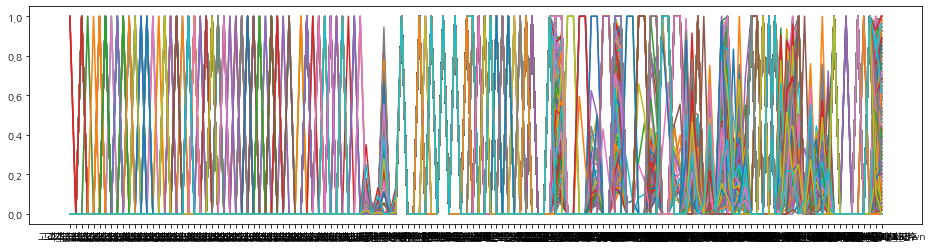

In [50]:
ax = plt.figure(figsize=(16,4))
legend_list = []
tmp = []
for i in tqdm_notebook(거래스케일.index[:500]):
    legend_list.append(i)
    sns.lineplot(거래스케일.loc[i].index, 거래스케일.loc[i].values)

#### 이상적인 거래 탐색을 위한 클러스터링이므로 밀도기반 클러스터일인 DBSCAN을 이용

0 130
1 283
2 36
3 58
4 308
5 83
6 90
7 89
8 13
9 47
10 54


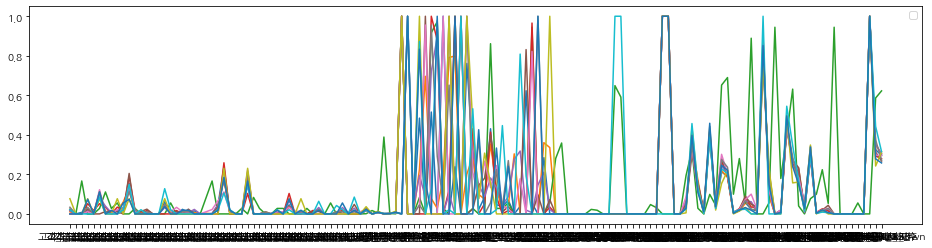

In [51]:
db = dbscan(trans_, eps=0.065, min_samples=30)
trans_['군집'] = db[1]
ax = plt.figure(figsize=(16,4))
legend_list = []
tmp = []
for i in range(len(set(db[1]))-1):
    legend_list.append(i)
    globals()['거래군집_{}'.format(i)] = 거래스케일[trans_['군집'] == i].mean().values
    globals()['스케일군집_{}'.format(i)] = trans_[trans_['군집'] == i].mean().values[:-1]
    sns.lineplot(거래스케일[trans_['군집'] == i].mean().index, 거래스케일[trans_['군집'] == i].mean().values)
    print(i, len(trans_[trans_['군집'] == i]))

plt.legend([])
plt.show()

#### 유저의 마지막 거래와 이상적인 거래와의 비교를 통해 적절한 컨텐츠를 추천

In [52]:
def cont_reco(clnt_id):
    tmp = trans_table[trans_table.notnull().T.all()]
    t_id = tmp['trans_id'][tmp['clnt_id'] == clnt_id].max()
    print(t_id)
    if not t_id:
        print('식별 가능한 거래가 없습니다.')
        return
    min_dist = 100000000
    similar_cluster = -1
    tmp = trans_.loc[t_id].values[:-1]
    tmp2 = 거래스케일.loc[t_id].values
    for i in range(len(trans_['군집'].unique())-1):
        if min_dist > np.linalg.norm(tmp - globals()['스케일군집_{}'.format(i)]):
            min_dist = np.linalg.norm(tmp - globals()['스케일군집_{}'.format(i)])
            similar_cluster = i

    print('유사군집:', similar_cluster)
    print('군집과의 거리:', min_dist)
    print()
    print('유사군집과 유저의 컬럼별 거리')
    for i in sorted(list(zip(tmp2 - globals()['거래군집_{}'.format(similar_cluster)], trans_.columns[:-1])), key=lambda x : abs(x[0]), reverse=True)[:10]:
        print(i)
        
    ax = plt.figure(figsize=(15,7))
    sns.lineplot(trans_.columns[:-1], 거래스케일[trans_['군집'] == similar_cluster].mean().values)
    sns.lineplot(trans_.columns[:-1], tmp2)
    plt.legend(['유사군집', '유저'])
    plt.title('유저와 유자군집 커브 비교')
    plt.show()

102857
유사군집: 1
군집과의 거리: 0.07995737325501204

유사군집과 유저의 컬럼별 거리
(0.9081272084805654, '행동_기기유형_mobile_web')
(-0.8975265017667845, '행동_기기유형_mobile_app')
(0.8904593639575972, '고객_군집_13.0')
(0.8657243816254416, '맥락_시간대_오후')
(0.773851590106007, '맥락_기온_낮음')
(-0.696113074204947, '맥락_기온_높음')
(0.6643109540636043, '맥락_요일_화')
(-0.36042402826855124, '맥락_요일_토')
(-0.35335689045936397, '맥락_시간대_오전')
(0.3517150301602595, '행동_세션_경과시간')


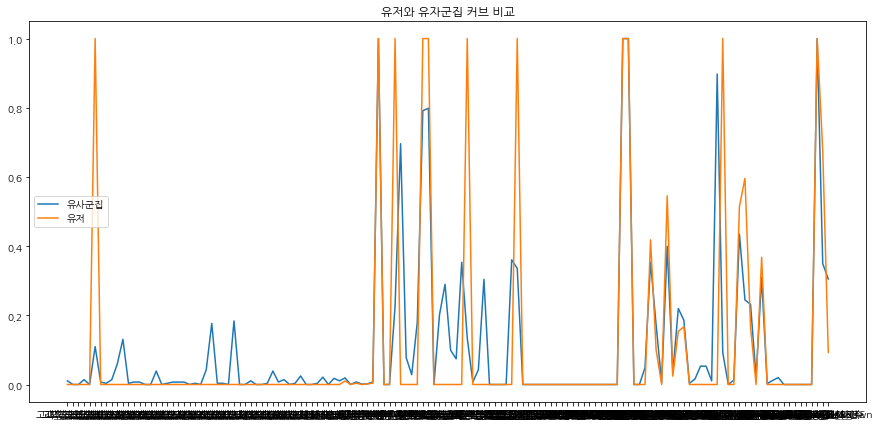

In [53]:
cont_reco(57)

세션 경과 시간이 지연됐으므로 샬롯과 쇼핑 도움 컨텐츠 추천

### 알고리즘 4: 객단가 증대

#### 1. 연관상품 추천

상품간의 조건부확률과 각 상품의 확률값을 이용하여 연관지수 계산

상품이 나올 확률을 배제하고 상품관의 연관성 측면에서만 볼 수 있음

In [54]:
trans_id_idx = transactions.set_index('trans_id')['clac_nm3']

In [55]:
item_tuple_to_cnt = {}
for i in tqdm_notebook(trans_id_idx.index.unique()):
    items_ = trans_id_idx.loc[i]
    if type(items_) is not str:
        visit = set()
        for j in range(len(items_)):
            tmp = list(items_)
            item = tmp.pop(j)
            if item in visit:
                continue
            visit.add(item)
            for k in set(tmp):
                item_tuple_to_cnt[(item,k)] = item_tuple_to_cnt.get((item,k), 0) + 1

In [56]:
item_to_cnt = {}
all_cnt = 0
for i in tqdm_notebook(trans_id_idx.index.unique()):
    items = trans_id_idx.loc[i]
    if type(items) is not str:
        all_cnt += 1
        for j in set(items):
            item_to_cnt[j] = item_to_cnt.get(j, 0) + 1

In [57]:
upgraded_dict = {}
for t in tqdm_notebook(item_tuple_to_cnt.keys()):
    if item_tuple_to_cnt[t] >= 5:
        upgraded_dict[t] = (item_tuple_to_cnt[t] / item_to_cnt[t[0]] / item_to_cnt[t[1]] * all_cnt , item_tuple_to_cnt[t])

In [61]:
items = items__.copy()
items_ = items.copy()
items_['pd_c'] = items_['pd_c'].astype('int')
items_ = items_.set_index('pd_c')

In [62]:
def item_reco1(pd_c):
    name = items_.loc[pd_c, 'clac_nm3']
    cnt = 0
    print('현재상품 : {}'.format(name))
    for i in sorted(upgraded_dict.items(), key=lambda x : -x[1][0]):
        if i[0][0] == name and i[0][1] != name:
            print('연관상품 : {}   연관지수 : {:.2f}'.format(i[0][1], i[1][0]))
            cnt += 1
            if cnt == 3:
                break
    if cnt == 0:
        print('5번 이상 동시 구매된 연관상품이 없습니다.')

In [63]:
item_reco1(pd_c=5)

현재상품 : Wiper Blades
연관상품 : Car Air Fresheners   연관지수 : 88.33
연관상품 : Washer Fluid   연관지수 : 84.69
연관상품 : Plums   연관지수 : 6.39


#### 2. 주기기반 추천

In [64]:
transactions_ = transactions.copy()
transactions_['de_dt'] = transactions_['de_dt'].apply(lambda x : dt.datetime.strptime(str(x), '%Y%m%d'))

In [65]:
개인별주기 = transactions_.pivot_table(index=['clnt_id', 'pd_c'], values='de_dt', aggfunc=lambda x : x.diff().mean())
개인별주기 = 개인별주기[개인별주기['de_dt'] > np.timedelta64(1000,'ns')]
개인별주기

de_dt
clnt_id pd_c                 
2       0092  1 days 12:00:00
9       0347 47 days 00:00:00
        0515 58 days 00:00:00
        0517 29 days 00:00:00
        0952 49 days 00:00:00
...                       ...
72424   0864  4 days 12:00:00
        0960 59 days 00:00:00
        0964  9 days 00:00:00
        1210 29 days 12:00:00
        1395 29 days 12:00:00

[90536 rows x 1 columns]

In [66]:
상품별주기 = 개인별주기.reset_index().pivot_table(index='pd_c', values='de_dt', aggfunc=lambda x : x.mean() if len(x) > 10 else np.timedelta64(0,'ns'))
상품별주기 = 상품별주기[상품별주기['de_dt'] > np.timedelta64(1000,'ns')]
상품별주기

,de_dt
pd_c,
0030,11 days 06:32:05.547391
0031,14 days 14:32:00
0032,16 days 04:28:21.873334
0033,12 days 08:19:56.018623
0064,6 days 23:08:34.285714
...,...
1663,12 days 09:40:06.857142
1664,12 days 00:57:01.353383
1666,16 days 17:10:11.040790


In [67]:
마지막구매 = transactions_.pivot_table(index=['clnt_id', 'pd_c'], values='de_dt', aggfunc='max')
마지막구매

de_dt
clnt_id pd_c           
2       0092 2019-08-01
        0151 2019-07-31
        0186 2019-07-31
        0189 2019-07-31
        0351 2019-07-31
...                 ...
72424   1592 2019-07-27
        1600 2019-07-27
        1604 2019-09-24
        1608 2019-09-24
        1617 2019-09-24

[332184 rows x 1 columns]

#### 개인으로, 전체로 보았을때 해당 아이템 주기가 현재에 모두 다다랐으면 추천

In [68]:
def item_reco2(clnt_id):
    if len(개인별주기.loc[clnt_id]) == 0:
        print('주기가 유효한 상품이 없음')
        return
    cnt = 0
    for pd_c in 개인별주기.loc[clnt_id].index:
        if pd_c in 상품별주기.index:
            if (마지막구매.loc[(clnt_id, pd_c)] + 개인별주기.loc[(clnt_id, pd_c)] - dt.datetime.strptime('20191001', '%Y%m%d') < np.timedelta64(1,'D')).all() and (마지막구매.loc[(clnt_id, pd_c)] + 상품별주기.loc[pd_c] - dt.datetime.strptime('20191001', '%Y%m%d') < np.timedelta64(1,'D')).all():
                print('주기에 다다른 상품코드 : {}'.format(pd_c))
                print('상품 소분류 : {}'.format(items.set_index('pd_c').loc[pd_c, 'clac_nm3']))
                print()
                cnt += 1
    if cnt == 0:
        print('주기에 다다른 상품 없음')
                

#### clnt_id 72424 유저에 대한 주기기반 추천 결과

In [69]:
item_reco2(72424)

주기에 다다른 상품코드 : 0864
상품 소분류 : Fixed-price Living Products

주기에 다다른 상품코드 : 0964
상품 소분류 : Chicken Eggs



#### 무료배송 가격을 맞추기 위한 추천

A03 채널의 경우 롯데 프레시의 무료배송 기준 가격은 3만원에 거래 총 가격이 집중되어 있는 것을 볼 수 있음

이를 통해 3만원 대를 맞추기위해 사람들이 구매한 상품을 찾고 이를 가격 정보에 따라 추천

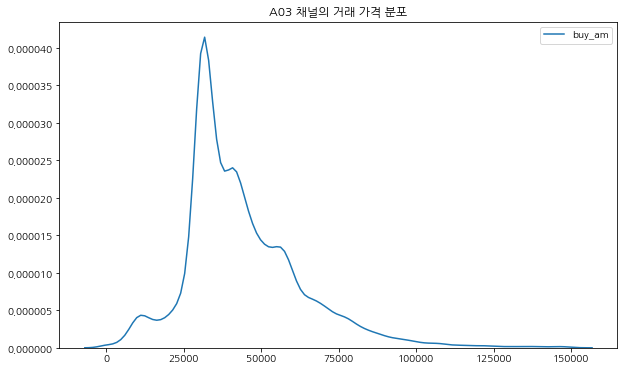

In [70]:
transactions_A03 = transactions[transactions['biz_unit'] == 'A03']
tmp = transactions_A03.pivot_table(index=['clnt_id', 'trans_id'], values='buy_am', aggfunc='sum')['buy_am']
tmp = tmp[tmp < 150000]
_, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(tmp, ax=ax)
plt.title('A03 채널의 거래 가격 분포')
plt.show()

In [71]:
transactions_A03 = transactions_A03.set_index(['trans_id', 'trans_seq'])

In [72]:
transactions_A03 = transactions_A03.sort_values(['trans_id', 'trans_seq'])

In [84]:
transactions_A03 = transactions_A03.loc[trans_table['trans_id'][(trans_table['구매_총거래액'] >= 30000) & (trans_table['구매_총거래액'] <= 35000)].values]
transactions_A03 = transactions_A03[transactions_A03.notnull().T.all()]

In [74]:
transactions_ = transactions.copy()
transactions_['buy_ct'][transactions_['buy_ct'] == 0] = 1
제품당평균가격 = transactions_.pivot_table(index='pd_c', aggfunc=lambda x : (x['buy_am'] / x['buy_ct']).mean())['buy_am']

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [75]:
last_seq = 0
last_item = 0
item_list = []
for i in transactions_A03.index:
    if i[1] <= last_seq:
        try:
            item_list.append((last_item, items_.loc[int(last_item), 'clac_nm3'], 제품당평균가격.loc[last_item]))
        except:
            pass
    last_seq = i[1]
    last_item = transactions_A03.loc[i, 'pd_c']

In [76]:
Counter(item_list).most_common()

[(('0964', 'Chicken Eggs', 4205.48139151297), 408),
 (('0114', 'Water', 3988.5003761836274), 297),
 (('0347', 'Fresh Milk', 3233.0856969549463), 269),
 (('0348', 'Functional Milk', 3177.3622808411474), 182),
 (('1395', 'Ramens', 2840.8631204171434), 178),
 (('1394', 'Bibim Ramens', 3196.613756850131), 144),
 (('0174', 'Chilled Chicken, Jokbal and Pork Feet', 7841.373822143699), 111),
 (('0354', 'Spoon Type Yogurts', 2369.0799176270257), 107),
 (('0516', 'Frozen Fried Foods', 6309.70915896081), 99),
 (('1401', 'Instant Rice', 8388.087764020393), 94),
 (('1617', 'Tofu', 2266.221703971911), 93),
 (('0952', 'Domestic Porks - Bellys', 11732.486530528051), 92),
 (('0538', 'Grapes', 11415.170376373131), 85),
 (('0565', 'Bananas', 3100.861151821093), 82),
 (('0548', 'Watermelons', 13075.289226319595), 77),
 (('1213', 'General Snacks', 1614.547977613037), 74),
 (('0542', 'Peaches', 9683.879800096649), 70),
 (('0518', 'Frozen Korean Pancakes', 7052.250213019768), 66),
 (('0515', 'Frozen Dumpling

#### 현재 장바구니 가격에 따른 알고리즘 무료배송 맞추기 추천 알고리즘

In [77]:
def item_reco3(price):
    for i in Counter(item_list).most_common():
        if price + i[0][2] >= 30000 and i[0][2] < 1000000:
            print('평균 가격 {:.2f}원의 {} 추천'.format(i[0][2], i[0][1]))
            return

In [78]:
item_reco3(28000)

평균 가격 4205.48원의 Chicken Eggs 추천


### SVD++

index를 clnt_id로, column을 pd_c로 가지는 유저x아이템 행렬을 만들어 그 값을 해당 유저가 해당 아이템에 지출한 총 금액으로 한다.

그 후에 각 값이 평점과 같이 [1,2,3,4,5] 범위의 데이터를 가지도록 아이템별로 5분위등분(qcut) 을 시행한 뒤에 SVD++ 알고리즘을 학습한다.

In [79]:
from surprise import SVDpp
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

transactions = pd.read_csv('data/제6회 L.POINT Big Data Competition-분석용데이터-02.거래 정보.csv', encoding='utf-8')
tmp = transactions[transactions['pd_c'] != 'unknown'].copy()
tmp['pd_c'] = tmp['pd_c'].astype('int')
tmp = tmp.pivot_table(index=['clnt_id', 'pd_c'], values='buy_am', aggfunc='sum').reset_index()
for i in tmp['pd_c'].unique():
    try:
        tmp['buy_am'][tmp['pd_c'] == i] = pd.qcut(tmp['buy_am'][tmp['pd_c'] == i], 5, labels=range(1,6))
    except:
        tmp = tmp[tmp['pd_c'] != i]
tmp = tmp.astype('int')

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(tmp[['clnt_id', 'pd_c', 'buy_am']], reader)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


#### 검증을 위해 500개의 데이터를 학습셋에서 제거, 검증셋으로 저장해 둠

In [89]:
cnt = 0
y = []
id_cnt = tmp.pivot_table(index='clnt_id', values='buy_am', aggfunc='count').to_dict()['buy_am']
id_dict = tmp['clnt_id'].to_dict()
buy_am_dict = tmp['buy_am'].to_dict()
pd_c_dict = tmp['pd_c'].to_dict()
for i in tmp.index:
    if id_cnt[id_dict[i]] > 10 and buy_am_dict[i] == 5 and np.random.rand() > 0.9:
        y.append((id_dict[i], pd_c_dict[i], buy_am_dict[i]))
        tmp.drop(i, inplace=True)
        cnt += 1
    if cnt == 500:
        break

#### GridSearchCV를 통해 찾은 최적의 하이퍼파라미터

In [81]:
param_grid = {'n_factors':[7], 'n_epochs':[7], 'init_mean':[0],'lr_all':[0.006], 'reg_all':[0.01]}
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=5, refit=True)
gs.fit(data)

print(gs.best_score['mae'])

1.2310070313431025


cv=5의 kfold 검증에서 1.229의 MAE score 기록

In [90]:
cnt = 0
for i in y:
    tmp1 = []
    for j in tmp['pd_c'].unique():
        tmp1.append((gs.predict(i[0], j).est, j))
    tmp2 = []
    for j in sorted(tmp1, reverse=True)[:10]:
        if j[1] == i[1]:
            cnt += 1
            break

In [91]:
print(cnt / len(y))

0.124


1600개의 아이템 중 10개를 추천 하였을 때 맞출 확률 13.4%

#### SVD++ 기반 상품 추천 10개

In [98]:
def item_reco(clnt_id):
    cnt = 0
    tmp1 = []
    print('clnt_id {} 를 위한 추천상품 10개:'.format(clnt_id))
    for i in tmp['pd_c'].unique():
        tmp1.append((gs.predict(clnt_id, i).est, i))
    for j in sorted(tmp1, reverse=True)[:10]:
        print('추천 상품 : {}   추천 지수 : {}'.format(items_.loc[int(j[1]), 'clac_nm3'], j[0]))


#### SVD++ 기반 상품 추천 10개

In [99]:
item_reco(2)

clnt_id 2 를 위한 추천상품 10개:
추천 상품 : General Dishwashing Liquids   추천 지수 : 3.622099898420372
추천 상품 : Australian Imported Beefs - Shoulders   추천 지수 : 3.60385510674875
추천 상품 : Toothpaste   추천 지수 : 3.5811645467971496
추천 상품 : Imported Beer   추천 지수 : 3.5024572041809985
추천 상품 : Hair Shampoos   추천 지수 : 3.48547745971614
추천 상품 : Chocolate Plates   추천 지수 : 3.4624322786827864
추천 상품 : Domestic Beefs - Briskets   추천 지수 : 3.4523597899305356
추천 상품 : Sanitary Pads   추천 지수 : 3.449512989978316
추천 상품 : Doenjang   추천 지수 : 3.420966573138447
추천 상품 : Chocolate Bars   추천 지수 : 3.420702133592374
